In [27]:
import joblib
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lime.lime_tabular
import lime.lime_image
import warnings

sys.path.append('../')

import shap

plt.style.use('seaborn-paper')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('lines', markersize=10)

warnings.filterwarnings('ignore')
from src import LogisticRegression, metrics
from sklearn.model_selection import train_test_split

In [28]:
df = pd.read_csv('../dataset/breast-cancer-wisconsin-processed.csv')
label = pd.read_csv('../dataset/breast-cancer-wisconsin-processed-label.csv')
data = pd.concat([df, label], axis=1)

In [29]:
X = data.drop('diagnosis', axis=1)
y = data['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

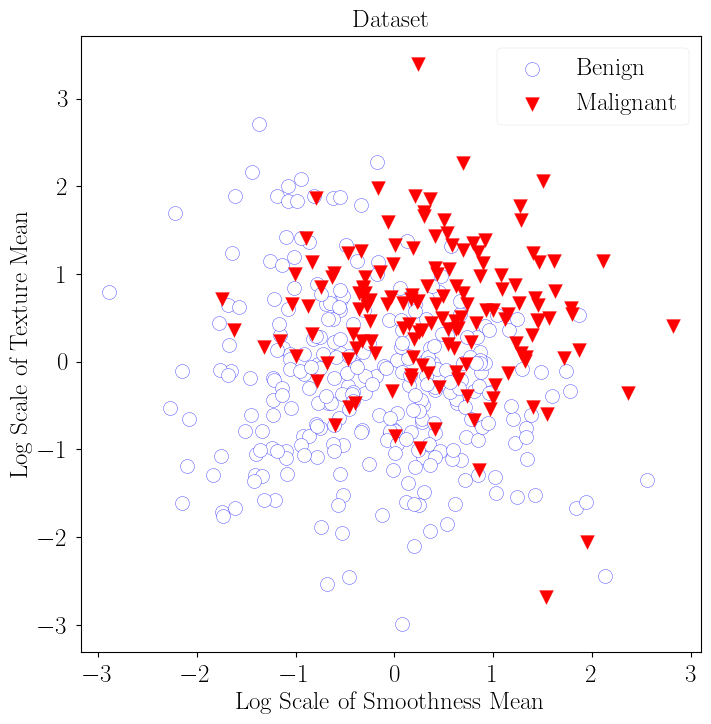

In [30]:
plt.subplots(figsize=(8, 8))
plt.title('Dataset')
plt.scatter(X_train[y_train == 0]['smoothness_mean_log'], X_train[y_train == 0]['texture_mean_log'], marker='o',
            label='Benign', s=100, edgecolors='blue', facecolors='white')
plt.scatter(X_train[y_train == 1]['smoothness_mean_log'], X_train[y_train == 1]['texture_mean_log'], marker='v',
            label='Malignant', s=100, edgecolors='red', facecolors='red')
plt.xlabel('Log Scale of Smoothness Mean')
plt.ylabel('Log Scale of Texture Mean')
plt.legend()
plt.show()

In [31]:
# Tuning the hyperparameters
learning_rates = [0.001, 0.01, 0.1, 1, 5, 10]
max_iters = [100, 200, 400, 500, 1000, 1500]

'''best_learning_rate, best_max_iter, best_accuracy = LogisticRegression.cross_validation_lr(X_train, y_train,
                                                                                          learning_rates, max_iters,
                                                                                          k=10, verbose=True)'''

'best_learning_rate, best_max_iter, best_accuracy = LogisticRegression.cross_validation_lr(X_train, y_train,\n                                                                                          learning_rates, max_iters,\n                                                                                          k=10, verbose=True)'

In [32]:
best_learning_rate, best_max_iter = 5, 1000
model = LogisticRegression.LogisticRegression(learning_rate=best_learning_rate, max_iter=best_max_iter, verbose=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [33]:
metrics.classification_summary(y_test, y_pred)

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        71
           1       0.97      0.97      0.97        37

    accuracy                           0.98       108
   macro avg       0.98      0.98      0.98       108
weighted avg       0.98      0.98      0.98       108



Confusion matrix:
[[70  1]
 [ 1 36]]


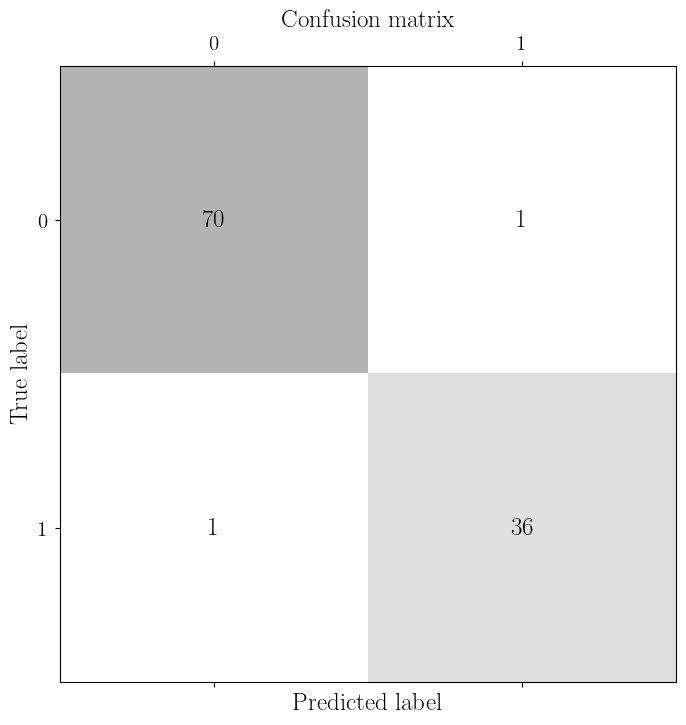

In [34]:
metrics.confusion_matrix(y_test, y_pred)

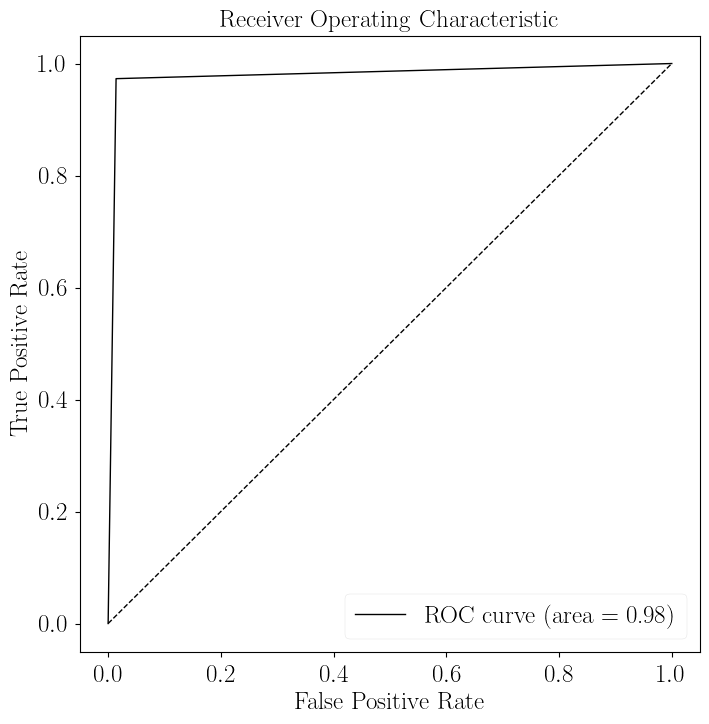

In [35]:
metrics.roc_curve(y_test, y_pred)

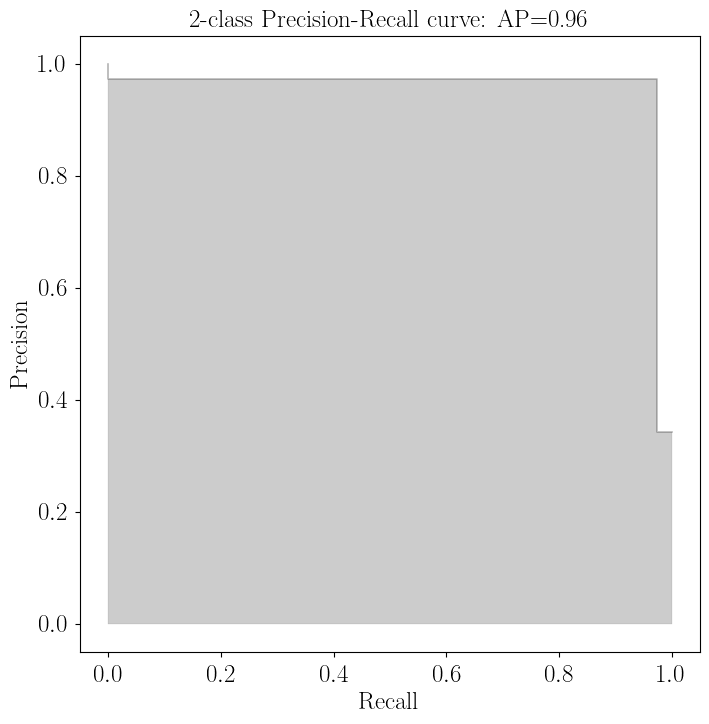

In [36]:
metrics.precision_recall_curve(y_test, y_pred)

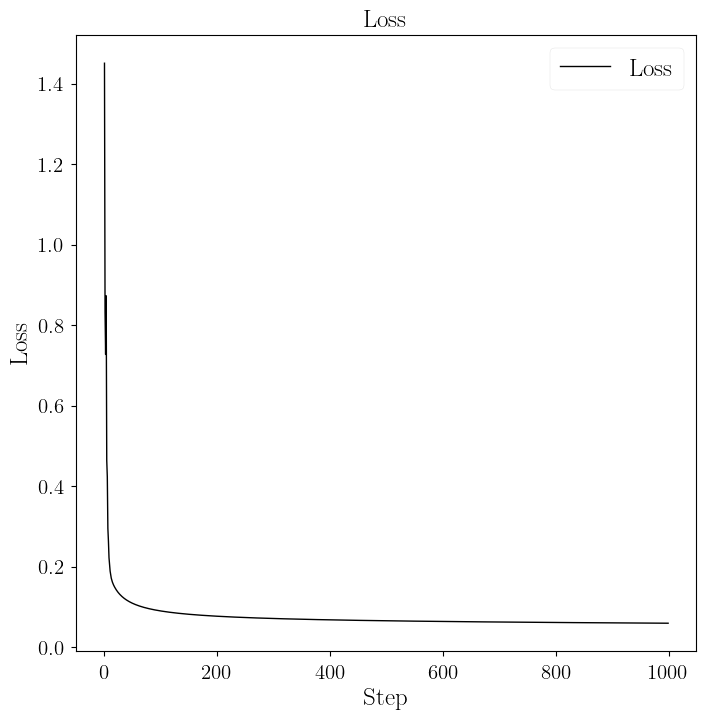

In [37]:
metrics.loss_curve(model.losses)

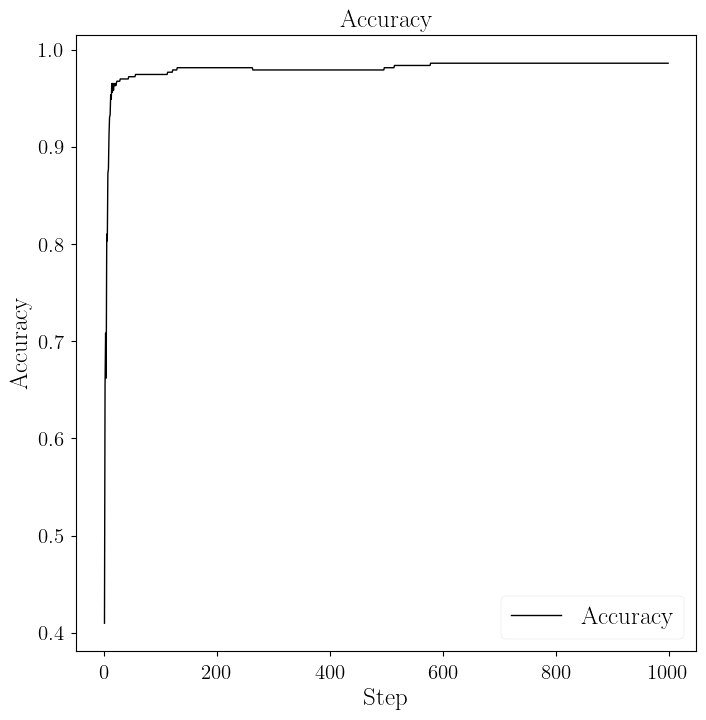

In [38]:
metrics.accuracy_curve(model.accuracies)

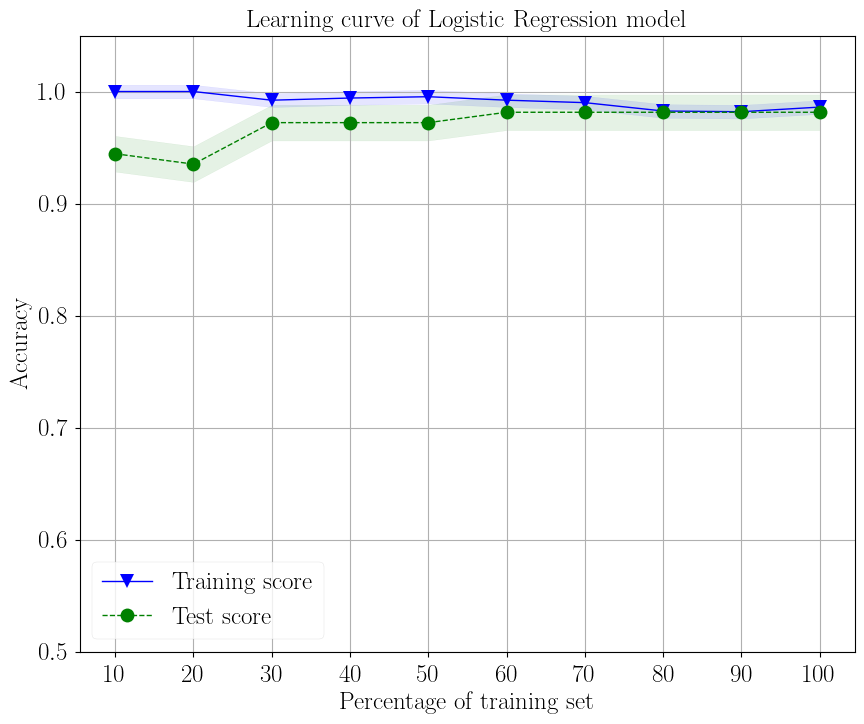

In [39]:
metrics.learning_curve_lr(X_train, y_train, X_test, y_test, best_learning_rate, best_max_iter)

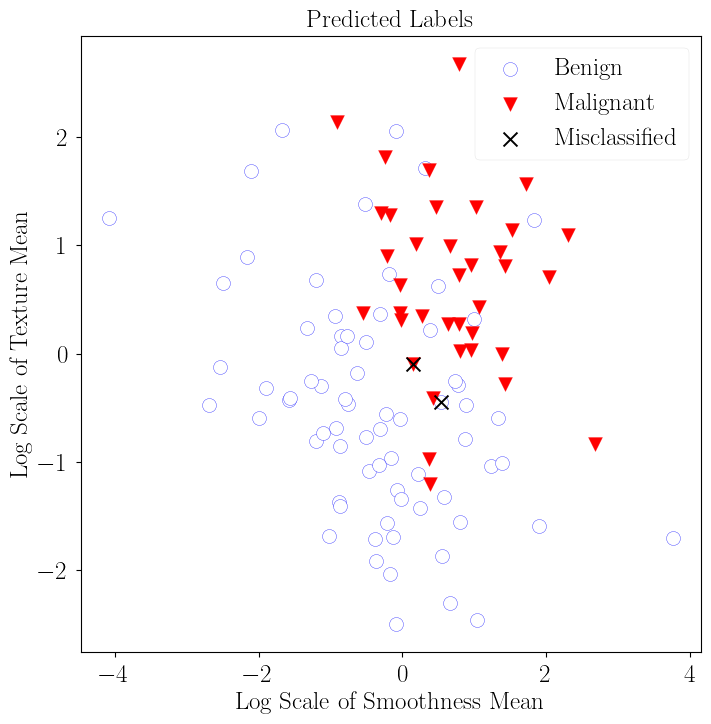

In [40]:
plt.subplots(figsize=(8, 8))
plt.title('Predicted Labels')
plt.scatter(X_test[y_pred == 0]['smoothness_mean_log'], X_test[y_pred == 0]['texture_mean_log'], marker='o',
            label='Benign', s=100, edgecolors='blue', facecolors='white')
plt.scatter(X_test[y_pred == 1]['smoothness_mean_log'], X_test[y_pred == 1]['texture_mean_log'], marker='v',
            label='Malignant', s=100, edgecolors='red', facecolors='red')
plt.scatter(X_test[y_pred != y_test]['smoothness_mean_log'], X_test[y_pred != y_test]['texture_mean_log'], marker='x',
            label='Misclassified', s=100, edgecolors='black', facecolors='black')
plt.xlabel('Log Scale of Smoothness Mean')
plt.ylabel('Log Scale of Texture Mean')
plt.legend()
plt.show()

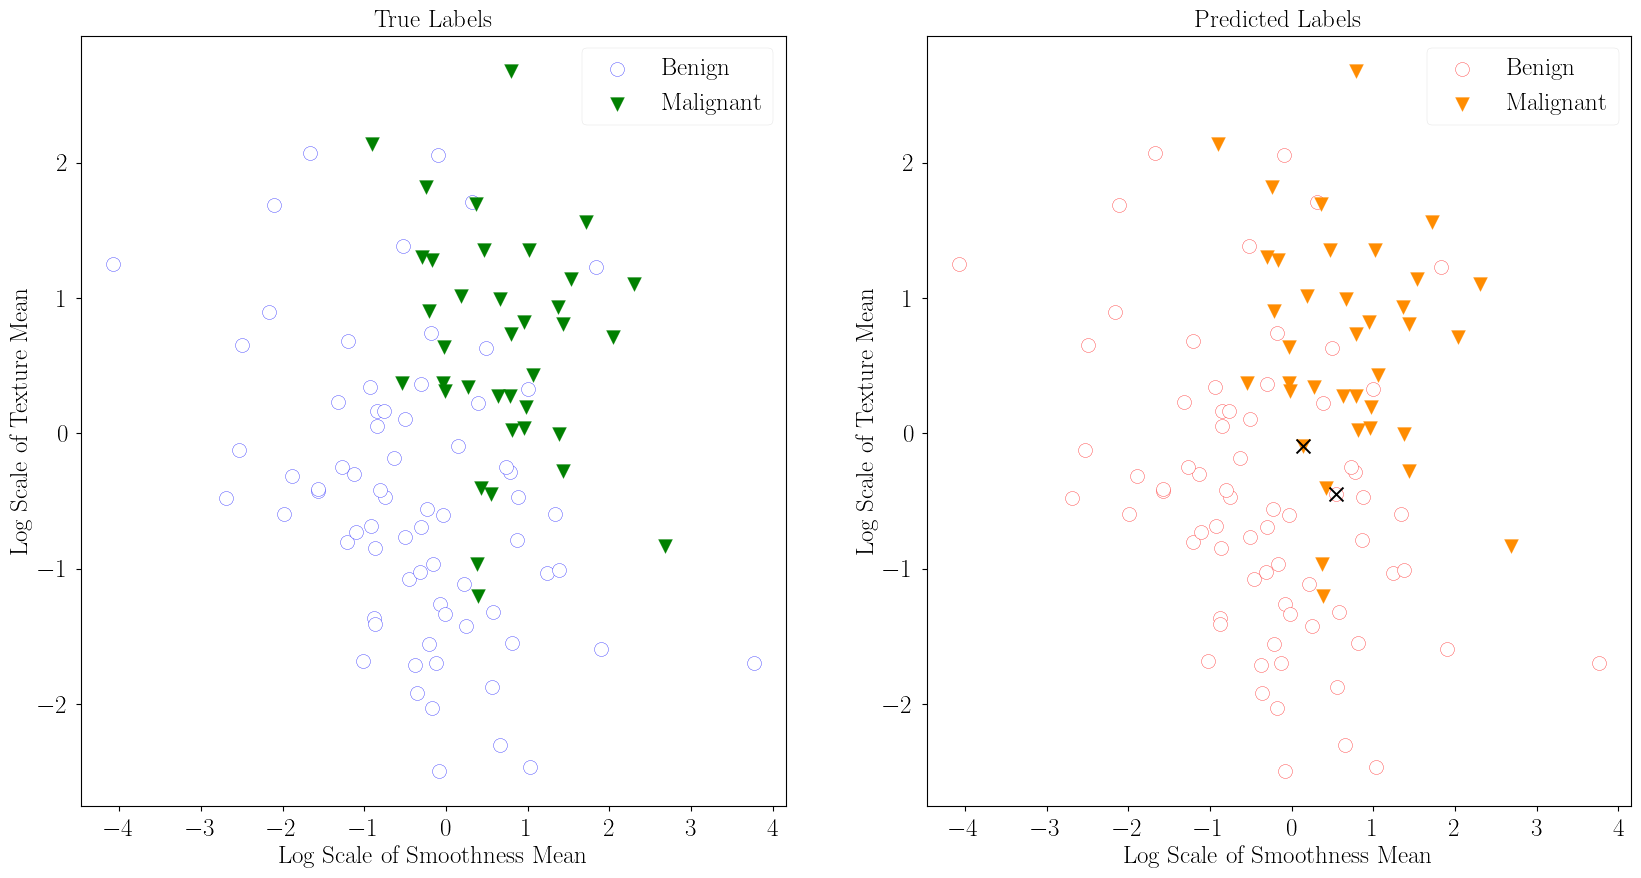

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title('True Labels')
ax[0].scatter(X_test[y_test == 0]['smoothness_mean_log'], X_test[y_test == 0]['texture_mean_log'], marker='o',
              label='Benign', s=100, edgecolors='blue', facecolors='white')
ax[0].scatter(X_test[y_test == 1]['smoothness_mean_log'], X_test[y_test == 1]['texture_mean_log'], marker='v',
              label='Malignant', s=100, edgecolors='green', facecolors='green')
ax[0].set_xlabel('Log Scale of Smoothness Mean')
ax[0].set_ylabel('Log Scale of Texture Mean')
ax[0].legend()

ax[1].set_title('Predicted Labels')
ax[1].scatter(X_test[y_pred == 0]['smoothness_mean_log'], X_test[y_pred == 0]['texture_mean_log'], marker='o',
              label='Benign', s=100, edgecolors='red', facecolors='white')
ax[1].scatter(X_test[y_pred == 1]['smoothness_mean_log'], X_test[y_pred == 1]['texture_mean_log'], marker='v',
              label='Malignant', s=100, edgecolors='darkorange', facecolors='darkorange')
ax[1].set_xlabel('Log Scale of Smoothness Mean')
ax[1].set_ylabel('Log Scale of Texture Mean')
ax[1].legend()
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        ax[1].scatter(X_test.iloc[i]['smoothness_mean_log'], X_test.iloc[i]['texture_mean_log'], marker='x',
                      label='Incorrect', s=100, edgecolors='black', facecolors='black')
plt.show()

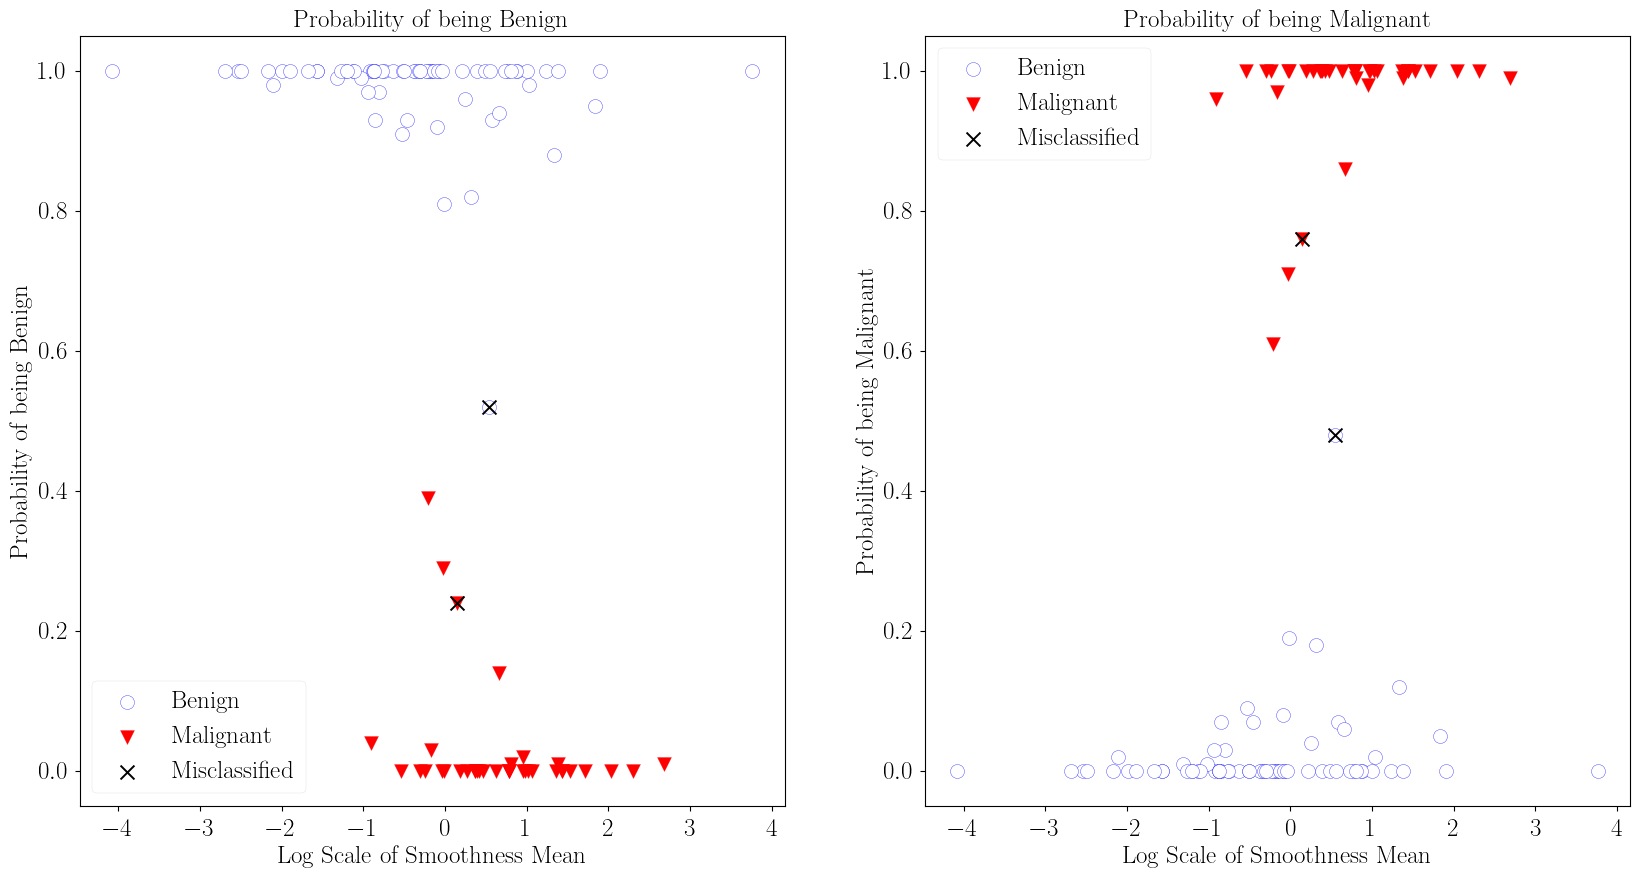

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title('Probability of being Benign')
ax[0].scatter(X_test[y_pred == 0]['smoothness_mean_log'], model.predict_proba(X_test[y_pred == 0])[:, 0], marker='o',
              label='Benign', s=100, edgecolors='blue', facecolors='white')
ax[0].scatter(X_test[y_pred == 1]['smoothness_mean_log'], model.predict_proba(X_test[y_pred == 1])[:, 0], marker='v',
              label='Malignant', s=100, edgecolors='red', facecolors='red')
ax[0].scatter(X_test[y_pred != y_test]['smoothness_mean_log'], model.predict_proba(X_test[y_pred != y_test])[:, 0],
              marker='x', label='Misclassified', s=100, edgecolors='black', facecolors='black')
ax[0].set_xlabel('Log Scale of Smoothness Mean')
ax[0].set_ylabel('Probability of being Benign')
ax[0].legend()
ax[1].set_title('Probability of being Malignant')
ax[1].scatter(X_test[y_pred == 0]['smoothness_mean_log'], model.predict_proba(X_test[y_pred == 0])[:, 1], marker='o',
              label='Benign', s=100, edgecolors='blue', facecolors='white')
ax[1].scatter(X_test[y_pred == 1]['smoothness_mean_log'], model.predict_proba(X_test[y_pred == 1])[:, 1], marker='v',
              label='Malignant', s=100, edgecolors='red', facecolors='red')
ax[1].scatter(X_test[y_pred != y_test]['smoothness_mean_log'], model.predict_proba(X_test[y_pred != y_test])[:, 1],
              marker='x', label='Misclassified', s=100, edgecolors='black', facecolors='black')
ax[1].set_xlabel('Log Scale of Smoothness Mean')
ax[1].set_ylabel('Probability of being Malignant')
ax[1].legend()
plt.show()

Using 432 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/108 [00:00<?, ?it/s]

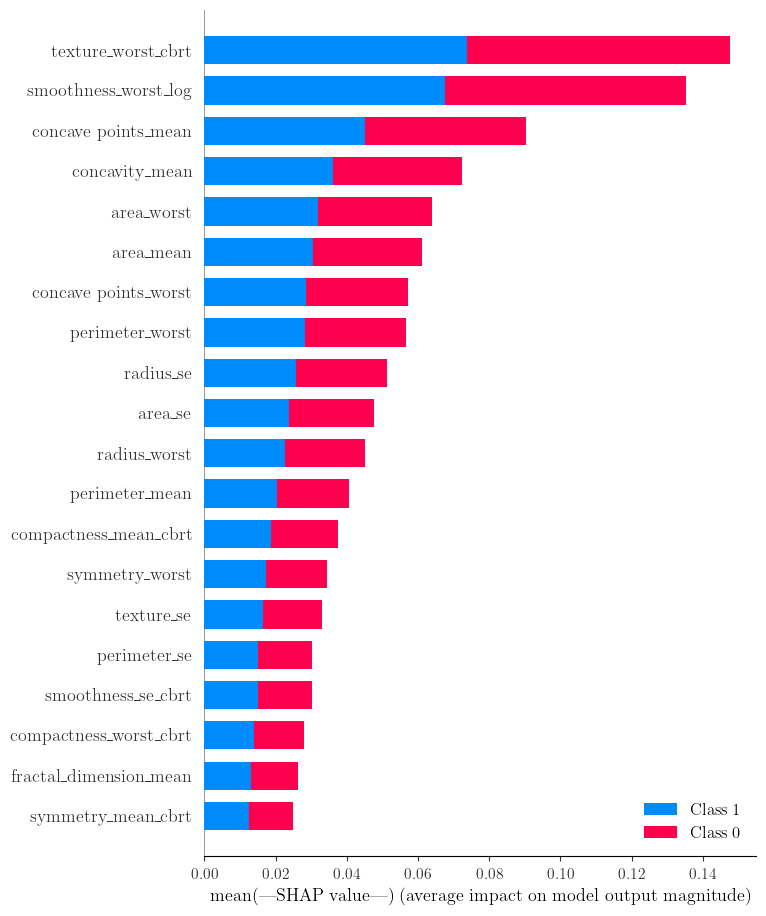

In [43]:
shape_explainer = shap.KernelExplainer(model.predict_proba, X_train)
shap_values = shape_explainer.shap_values(X_test, nsamples=100)
shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)
# plt.savefig('output_plots/LR_shap_summary_plot.png')
plt.show()

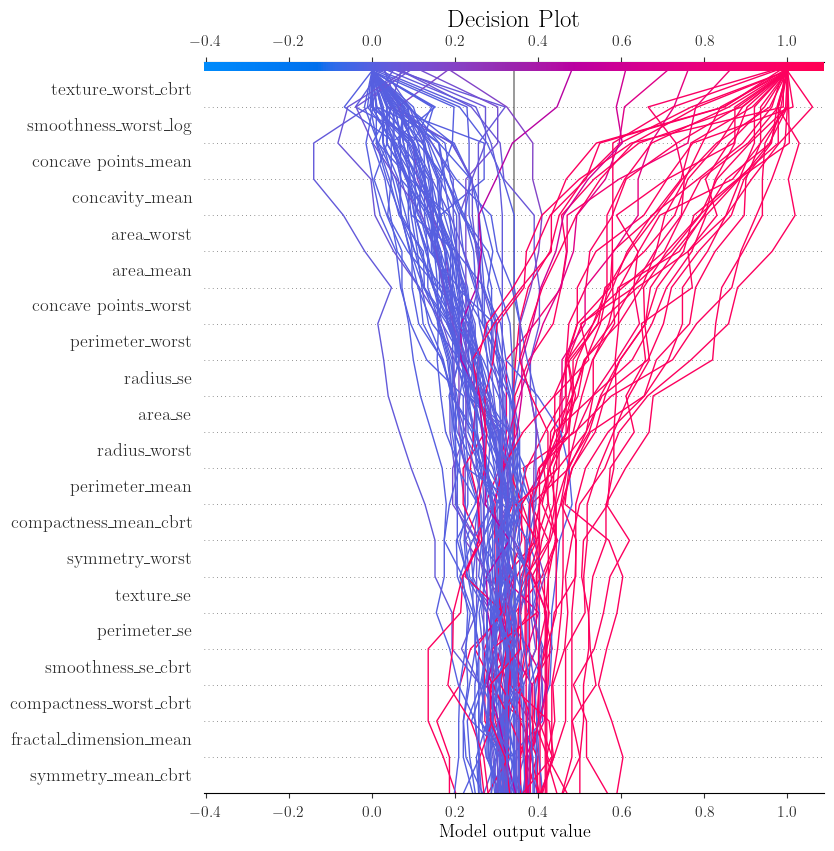

In [44]:
# Plot the shap decision plot
shap.decision_plot(shape_explainer.expected_value[1], shap_values[1], X_test, show=False)
plt.title('Decision Plot')
plt.show()

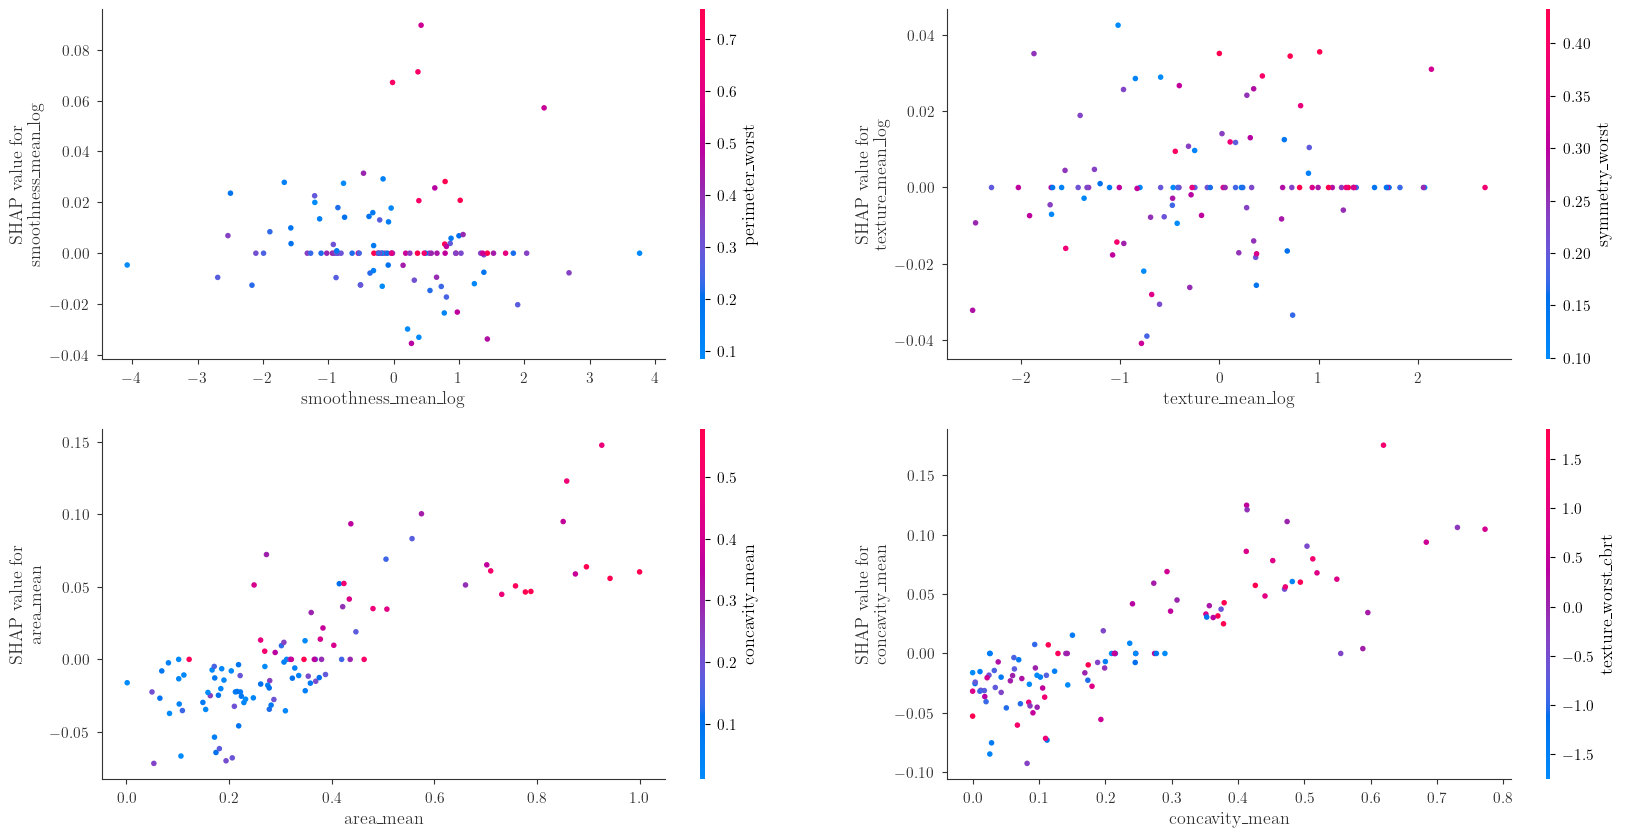

In [45]:
# Plot dependence plot for 4 most important features
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
shap.dependence_plot('smoothness_mean_log', shap_values[1], X_test, show=False, ax=ax[0, 0])
shap.dependence_plot('texture_mean_log', shap_values[1], X_test, show=False, ax=ax[0, 1])
shap.dependence_plot('area_mean', shap_values[1], X_test, show=False, ax=ax[1, 0])
shap.dependence_plot('concavity_mean', shap_values[1], X_test, show=False, ax=ax[1, 1])
# plt.savefig('../src/output_plots/LR_shap_dependence_plot.png')
plt.show()

In [46]:
misclassified = X_test[y_pred != y_test]

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns,
                                                   class_names=['Benign', 'Malignant'],
                                                   discretize_continuous=True, verbose=True, mode='classification')
for i in misclassified.index:
    exp = explainer.explain_instance(X_test.loc[i].values, model.predict_proba, num_features=10)
    exp.show_in_notebook(show_table=True, show_all=True)

Intercept 0.24239470696158855
Prediction_local [0.95016516]
Right: 0.76


Intercept 0.33054296143213363
Prediction_local [0.70815176]
Right: 0.48


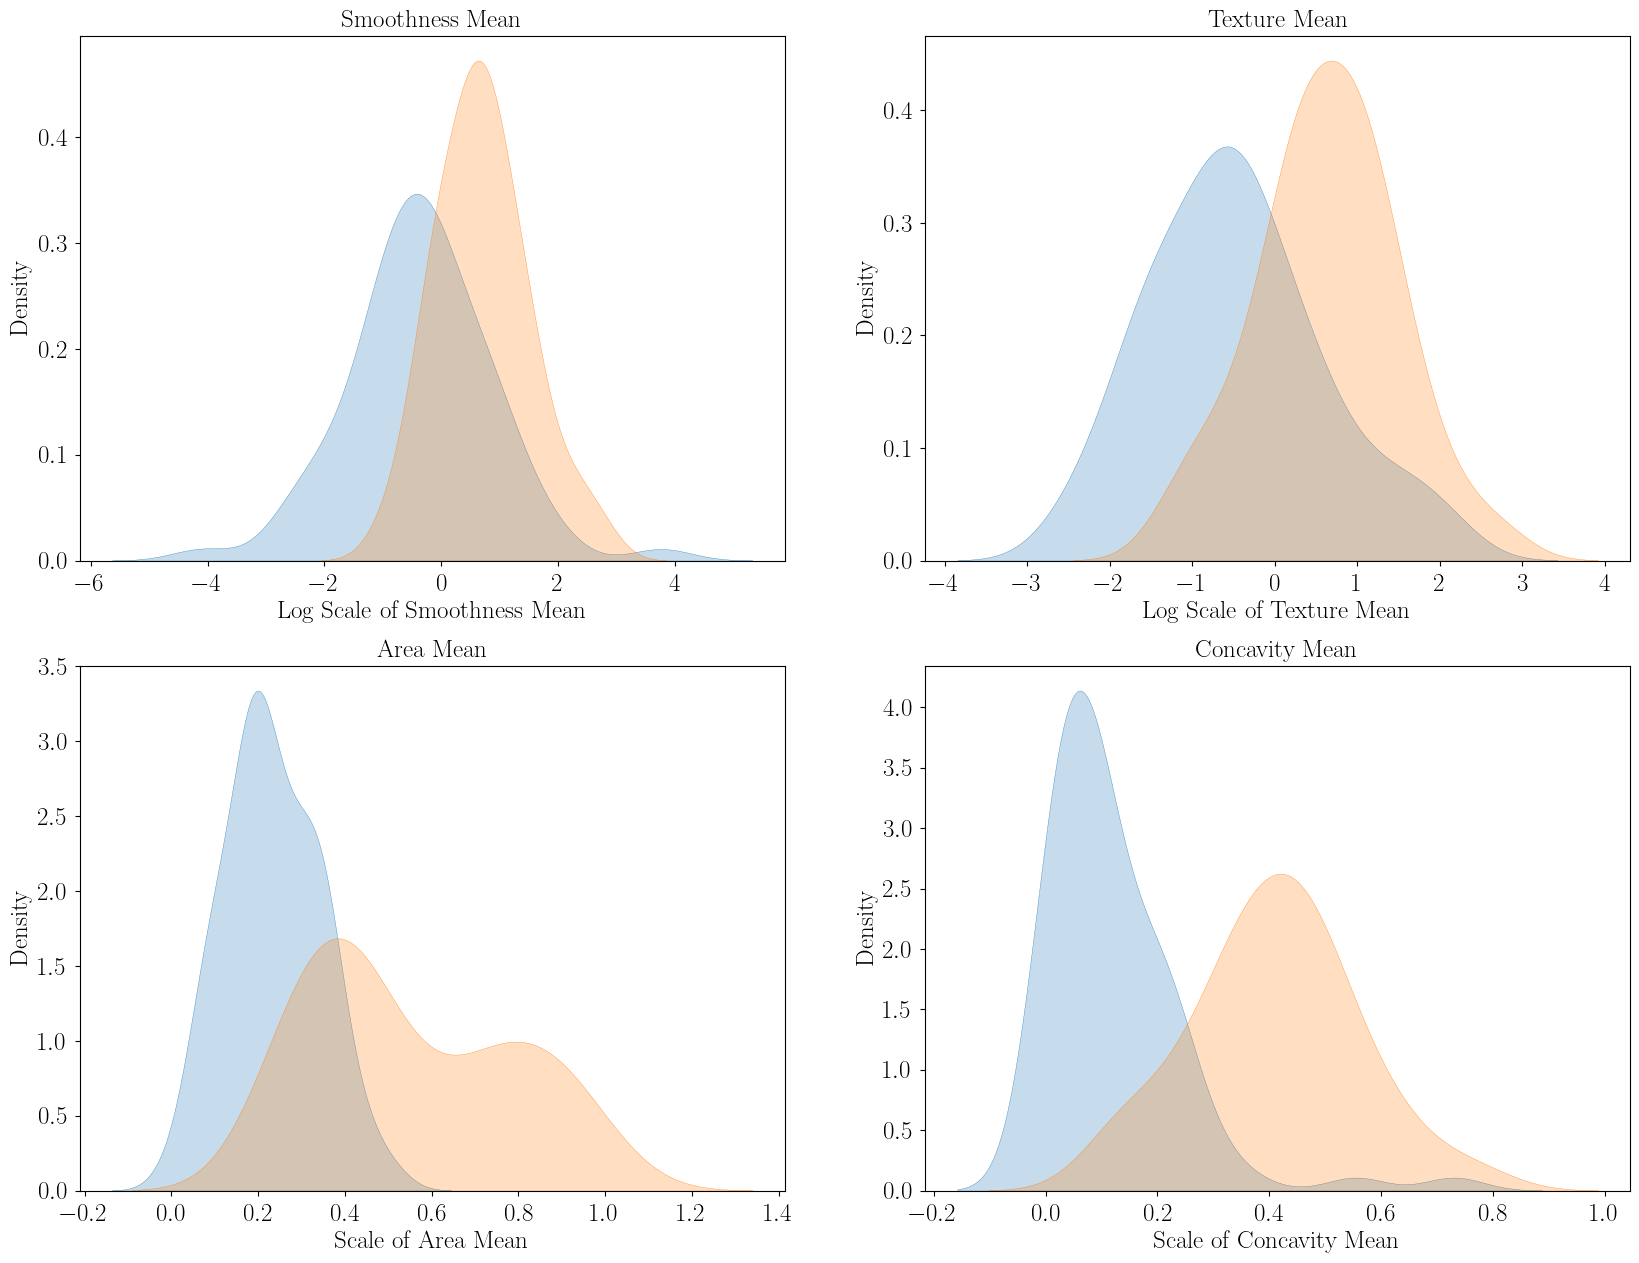

In [60]:
# Density chart for two class with scale of 4 most important features
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
sns.kdeplot(X_test[y_test == 0]['smoothness_mean_log'], label='Benign', shade=True, ax=ax[0, 0])
sns.kdeplot(X_test[y_test == 1]['smoothness_mean_log'], label='Malignant', shade=True, ax=ax[0, 0])
ax[0, 0].set_title('Smoothness Mean')
ax[0, 0].set_xlabel('Log Scale of Smoothness Mean')
ax[0, 0].set_ylabel('Density')
sns.kdeplot(X_test[y_test == 0]['texture_mean_log'], label='Benign', shade=True, ax=ax[0, 1])
sns.kdeplot(X_test[y_test == 1]['texture_mean_log'], label='Malignant', shade=True, ax=ax[0, 1])
ax[0, 1].set_title('Texture Mean')
ax[0, 1].set_xlabel('Log Scale of Texture Mean')
ax[0, 1].set_ylabel('Density')
sns.kdeplot(X_test[y_test == 0]['area_mean'], label='Benign', shade=True, ax=ax[1, 0])
sns.kdeplot(X_test[y_test == 1]['area_mean'], label='Malignant', shade=True, ax=ax[1, 0])
ax[1, 0].set_title('Area Mean')
ax[1, 0].set_xlabel('Scale of Area Mean')
ax[1, 0].set_ylabel('Density')
sns.kdeplot(X_test[y_test == 0]['concavity_mean'], label='Benign', shade=True, ax=ax[1, 1])
sns.kdeplot(X_test[y_test == 1]['concavity_mean'], label='Malignant', shade=True, ax=ax[1, 1])
ax[1, 1].set_title('Concavity Mean')
ax[1, 1].set_xlabel('Scale of Concavity Mean')
ax[1, 1].set_ylabel('Density')
# plt.savefig('../src/output_plots/LR_density_chart.png')
plt.show()